In [1]:
import tensorflow as tf
print (tf.__version__)

2.4.1


In [2]:
tf.keras.backend.clear_session()

In [3]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import ZeroPadding2D

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import tensorflow_hub as hub

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
project_path = '/content/drive/My Drive/DogBreed_Classification/'

In [6]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip','r') as z:
  z.extractall()

In [7]:
labels = pd.read_csv(project_path+'labels.csv.zip')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
breed_count=labels['breed'].value_counts()
breed_count.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [9]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('dogbreed_cnn.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max',
                                                    min_delta=0.001,
                                                    patience=5,
                                                    verbose=1)
model_es=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.001,patience=5,mode='max',verbose=1)
model_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.01,patience=5,verbose=1,mode='auto',min_delta=0.0001)

In [10]:
IMG_SIZE=224
channels=3
EPOCHS=50
BATCH=32

In [11]:
x_features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  #train_img = tf.io.read_file('./train/{}.jpg'.format(f))
  #train_img = tf.image.decode_jpeg(train_img, channels=channels)
  #train_img = tf.image.convert_image_dtype(train_img, tf.float32)
  #train_img_resize = tf.image.resize(train_img, size=[IMG_SIZE, IMG_SIZE])

  #Using cv2.imread results in BGR images, instead of the standard RGB as below
  train_img = cv2.imread('./train/{}.jpg'.format(f),1) #0 for grayscale & 1 for color (o/p is bgr)
  train_img_resize = cv2.resize(train_img, (IMG_SIZE,IMG_SIZE))
  x_features.append(train_img_resize)
  label.append(img)

100%|██████████| 10222/10222 [00:36<00:00, 278.04it/s]


In [12]:
encoder = LabelEncoder()
label = encoder.fit_transform(label)
y_label=tf.keras.utils.to_categorical(label, num_classes=120, dtype='int')#, 120)

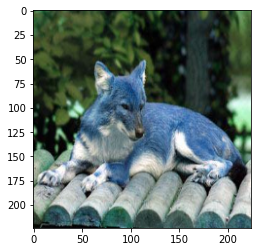

In [13]:
plt.imshow(x_features[42])

In [14]:
# Set number of images to use for experimenting
NUM_IMAGES = 5000
x_train,x_val,y_train,y_val=train_test_split(x_features[:NUM_IMAGES],
                                             y_label[:NUM_IMAGES],
                                             test_size=0.2,
                                             random_state=42)

In [15]:
x_train = np.array(x_train,np.float32)/255.0  #Division by 255. for normalisation
print(x_train.shape)

x_val = np.array(x_val,np.float32)/255.0  #Division by 255. for normalisation
print(x_val.shape)

y_train = np.array(y_train)
print(y_train.shape)

y_val = np.array(y_val)
print(y_val.shape)

(4000, 224, 224, 3)
(1000, 224, 224, 3)
(4000, 120)
(1000, 120)


In [16]:
# Setup input shape according to the pretrained-model input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channel ass

# Setup output shape of the model
OUTPUT_SHAPE = 120 # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [17]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)
  # Setup the model layers using sequential mode.
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 (the pre-trained model )
                               tf.keras.layers.Dense(units=512,activation="relu"), # Layer 2 (output layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") # Layer 3 (output layer)
                               ])
  # Compile the model
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])
  # Build the model
  model.build(INPUT_SHAPE)
  return model

In [18]:
# Create a model and check its details
model1 = create_model()
model1.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [19]:
history = model1.fit(x_train,y_train,
                     validation_data=(x_val,y_val),
                     epochs=EPOCHS,
                     batch_size=BATCH,
                     #callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/50
125/125 [==============================] - 236s 2s/step - loss: 3.8600 - accuracy: 0.2074 - val_loss: 1.4937 - val_accuracy: 0.5900
Epoch 2/50
125/125 [==============================] - 232s 2s/step - loss: 0.8756 - accuracy: 0.7786 - val_loss: 1.2731 - val_accuracy: 0.6480
Epoch 3/50
125/125 [==============================] - 234s 2s/step - loss: 0.4688 - accuracy: 0.8982 - val_loss: 1.2384 - val_accuracy: 0.6590
Epoch 4/50
125/125 [==============================] - 231s 2s/step - loss: 0.2756 - accuracy: 0.9576 - val_loss: 1.2365 - val_accuracy: 0.6540
Epoch 5/50
125/125 [==============================] - 233s 2s/step - loss: 0.1848 - accuracy: 0.9803 - val_loss: 1.2331 - val_accuracy: 0.6580
Epoch 6/50
125/125 [==============================] - 232s 2s/step - loss: 0.1199 - accuracy: 0.9939 - val_loss: 1.2519 - val_accuracy: 0.6640
Epoch 7/50
125/125 [==============================] - 232s 2s/step - loss: 0.0971 - accuracy: 0.9968 - val_loss: 1.2506 - val_accuracy: 0.6690

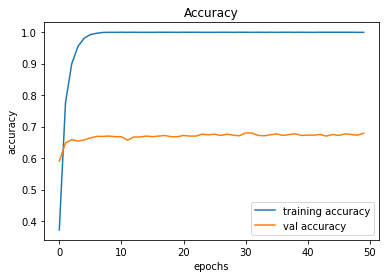

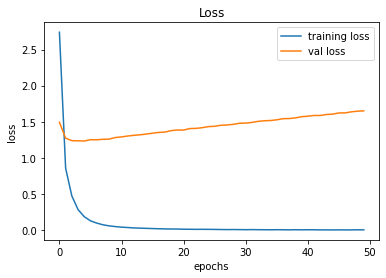

In [20]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [27]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(#preprocessing_function=preprocess_input,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                #rescale=1./255,
                                                                rotation_range=30,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                #vertical_flip=True,
                                                                fill_mode='nearest')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [28]:
training_data = train_datagen.flow(x_train,y=y_train,batch_size=BATCH)
testing_data = test_datagen.flow(x_val,y=y_val,batch_size=BATCH)

In [29]:
# Create a model and check its details
model2 = create_model()
model2.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_2 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [30]:
history = model2.fit(training_data,
                     epochs=EPOCHS,
                     steps_per_epoch= 4000//BATCH,  #Number of training images//batch_size
                     validation_data=testing_data,
                     validation_steps = 1000//BATCH, #Number of test images//batch_size,
                     #callbacks = [model_checkpoint,model_lr],
                     verbose=1)

Epoch 1/50
125/125 [==============================] - 276s 2s/step - loss: 5.7656 - accuracy: 0.0074 - val_loss: 5.9651 - val_accuracy: 0.0081
Epoch 2/50
125/125 [==============================] - 271s 2s/step - loss: 5.2432 - accuracy: 0.0079 - val_loss: 5.9723 - val_accuracy: 0.0091
Epoch 3/50
125/125 [==============================] - 271s 2s/step - loss: 5.2702 - accuracy: 0.0057 - val_loss: 5.9738 - val_accuracy: 0.0081
Epoch 4/50
125/125 [==============================] - 271s 2s/step - loss: 5.2516 - accuracy: 0.0100 - val_loss: 5.9805 - val_accuracy: 0.0071
Epoch 5/50
125/125 [==============================] - 270s 2s/step - loss: 5.2785 - accuracy: 0.0075 - val_loss: 5.9963 - val_accuracy: 0.0091
Epoch 6/50
 15/125 [==>...........................] - ETA: 3:20 - loss: 5.2884 - accuracy: 0.0092

KeyboardInterrupt: ignored

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()